In [1]:
import os
import joblib
import pickle

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_tests
import pingouin as pg
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u



plt.rcParams['pdf.fonttype']=42
%matplotlib inline

%load_ext autoreload
%autoreload 2

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
# load session
sparse_sessions = stx.ymaze_sess_deets.SparseKO_sessions
mouse = 'SparseKO_02'
d = sparse_sessions[mouse][-1]
date, scene, session, scan = d['date'], d['scene'], d['session'], d['scan']


pkldir = os.path.join('/home/mplitt/YMazeSessPkls', mouse,  date, f'{scene}_{session}.pkl')
sess = stx.session.YMazeSession.from_file(pkldir, verbose=False)


In [3]:
trial_masks = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}
channel_0_mask = sess.trial_info['block_number']%2==0
left_mask = sess.trial_info['LR']==-1


trial_masks['channel_0_left'] = channel_0_mask*left_mask
trial_masks['channel_0_right'] = channel_0_mask*~left_mask
trial_masks['channel_1_left'] = ~channel_0_mask*left_mask
trial_masks['channel_1_right'] = ~channel_0_mask*~left_mask


In [4]:
def run_shuffle(F, trial_starts, teleports, t, rng):
    
    F_shuff = np.zeros_like(F)
    
    for trial, (start, stop) in enumerate(zip(trial_starts, teleports)):
        _F = 1*F[:,start:stop]    
        _F = np.roll(_F,rng.integers(0,stop-start),axis=-1)
        F_shuff[:,start:stop] = 1*_F
        
    tmat = tpu.spatial_analyses.trial_matrix(F_shuff.T,t, trial_starts,
                                            teleports, min_pos=13, max_pos=43, bin_size=1, mat_only=True)
    
    return np.nanmean(tmat,axis=0)




In [5]:
rng = np.random.default_rng()

shuff_thresh = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}

F = sess.timeseries['channel_0_spks']
starts, stops = sess.trial_start_inds[trial_masks['channel_0_left']], sess.teleport_inds[trial_masks['channel_0_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_0_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)

F = sess.timeseries['channel_0_spks']
starts, stops = sess.trial_start_inds[trial_masks['channel_0_right']], sess.teleport_inds[trial_masks['channel_0_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_0_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)


F = sess.timeseries['channel_1_spks']
starts, stops = sess.trial_start_inds[trial_masks['channel_1_left']], sess.teleport_inds[trial_masks['channel_1_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_1_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)

F = sess.timeseries['channel_1_spks']
starts, stops = sess.trial_start_inds[trial_masks['channel_1_right']], sess.teleport_inds[trial_masks['channel_1_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_1_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)




In [6]:
trial_means = {'channel_0_left': np.nanmean(sess.trial_matrices['channel_0_spks'][trial_masks['channel_0_left'], : , :]),
               'channel_0_right': np.nanmean(sess.trial_matrices['channel_0_spks'][trial_masks['channel_0_right'], : , :]),
               'channel_1_left': np.nanmean(sess.trial_matrices['channel_1_spks'][trial_masks['channel_1_left'], : , :]),
               'channel_1_right': np.nanmean(sess.trial_matrices['channel_1_spks'][trial_masks['channel_1_right'], : , :]),
              }

In [7]:
import pickle
if False:
    with open('place_field_shuff_SparseKO_02.pkl','wb') as file:
        pickle.dump(shuff_thresh,file)

In [8]:
# import pickle 
# with open('place_field_shuff_SparseKO_02.pkl','rb') as file:
#     shuff_thresh = pickle.load(file)

In [9]:
field_info = {'channel_0_left': [],
               'channel_0_right': [],
               'channel_1_left': [],
               'channel_1_right': []}

for k, thresh in shuff_thresh.items():
    
    sig_bins = trial_means[k]>thresh

    # eliminate fields that start at first bin of track or end at last bin of track
    

    ledges = np.argwhere(sig_bins[1:,:]>sig_bins[:-1,:])
    
    for _ledge in ledges:

        rem_trial = sig_bins[_ledge[0]:,_ledge[1]]
        _redge = np.argwhere(rem_trial[1:]<rem_trial[:-1])
        # print(_redge.size)
        if (_redge.shape[0]>0) and (_redge[0][0]>2) and (_redge[0][0]<15) and (_ledge[0]>0):
            field_info[k].append([_ledge[1], _ledge[0], _redge[0][0]])


for k,v in field_info.items():
    field_info[k]=np.array(v)

(array([0.48717949, 0.37606838, 0.11111111, 0.02564103]),
 array([1., 2., 3., 4., 5.]),
 <BarContainer object of 4 artists>)

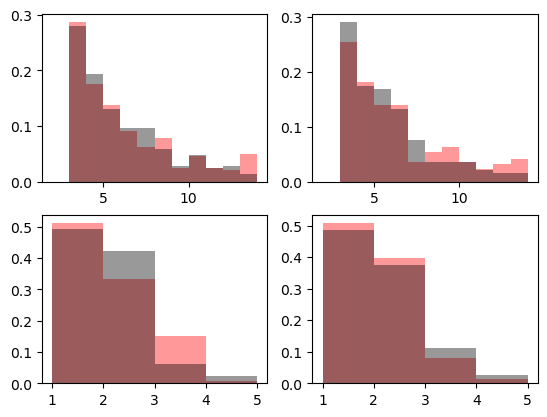

In [10]:
fig, ax = plt.subplots(2,2)

width_bins = np.arange(2,15)
field_bins = np.arange(1,6)
##
fi = field_info['channel_0_left']
ax[0,0].hist(fi[:,2], bins=width_bins, color='red', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,0].hist(nfields, bins=field_bins, color='red', alpha=.4, density=True)

##
fi = field_info['channel_1_left']
ax[0,0].hist(fi[:,2], bins=width_bins, color='black', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,0].hist(nfields, bins=field_bins, color='black', alpha=.4, density=True)

##
fi = field_info['channel_0_right']
ax[0,1].hist(fi[:,2], bins=width_bins, color='red', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,1].hist(nfields, bins=field_bins, color='red', alpha=.4, density=True)


##
fi = field_info['channel_1_right']
ax[0,1].hist(fi[:,2], bins=width_bins, color='black', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,1].hist(nfields, bins=field_bins, color='black', alpha=.4, density=True)


    